In [1]:
from rubin_sim.maf.metrics.baseMetric import BaseMetric
import rubin_sim.maf.utils as mafUtils
import rubin_sim.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metricBundles as metricBundles

import glob

In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 200, 20), 
                 atm_err=0.01, normalize=False, min_exp_time=15., 
                 exptimeCol='visitExposureTime', **kwargs):
        Cols = [m5Col, filterCol, seeingCol, exptimeCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.exptimeCol = exptimeCol
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        self.min_exp_time = min_exp_time
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            if self.min_exp_time is not None:
                good = np.where((dataslice[self.filterCol] == filt) &
                                (dataslice[self.exptimeCol] >= self.min_exp_time))[0]
            else:
                good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

In [4]:
# files = glob.glob('/sims_maf/fbs_2.0/long_gaps/*.db')
# files = glob.glob('/sims_maf/fbs_2.0/baseline/*.db')
# Doing my usual of just sym-linking the database into this directory
files = glob.glob('*.db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_2.0/',"GAPSresults/")
     
    print ("OUT", outDir)
    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 18.35, 'z': 16.68, 'y': 15.66}, metricName='L4')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    # add DCR degeneracy check...
    #sql = 'filter="z" or filter="y"'
    #metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
    #bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
    #                                         runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
#    bg.plotAll(closefigs=False)

#    results.append(bg)

OUT baseline_v2.0_10yrs_bdvol
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database None with no constraint for columns ['rotSkyPos', 'seeingFwhmGeom', 'filter', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'visitExposureTime'].
Found 2086980 visits
Running:  ['baseline_v2_0_10yrs_L4_HEAL']


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/astrometryUtils.py:76: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm / (snr)
/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_39150/3005278089.py:60: RuntimeWarning: divide by zero encountered in true_divide
  sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_39150/3005278089.py:61: RuntimeWarning: divide by zero encountered in true_divide
  sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_39150/3005278089.py:63: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.


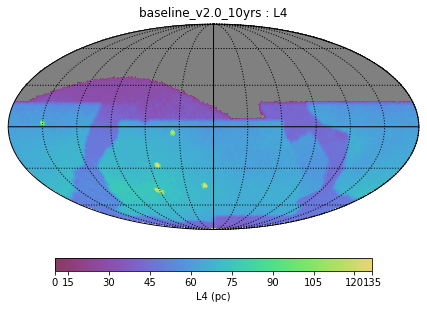

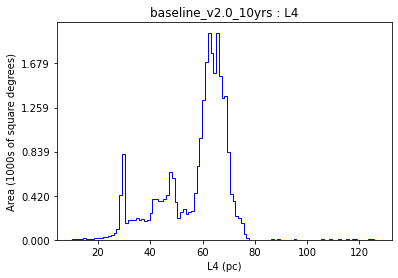

In [5]:
bg.plotAll(closefigs=False)

In [2]:
# Quick example of pulling out some data to play with
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
# and http://astro-lsst-01.astro.washington.edu:8080/
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
import os

baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [17]:
bundleList = []
# The point on the sky we would like to get visits for
ra = [0.]
dec = [-20]


# Say we just want to pass data through, not compute anything. 
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth',
                                      'ra_pi_amp', 'dec_pi_amp', 'seeingFwhmGeom'])
# Select all the visits in the first year
#sql = 'night < 365'
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name))

In [18]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database SummaryAllProps with constraint night < 365 for columns ['fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'rotSkyPos', 'observationStartMJD']
Found 211662 visits
Running:  ['baseline_nexp2_v1_7_10yrs_Pass_filter_observationStartMJD_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_night_lt_365_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [19]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundleList[0].metricValues[0]

array([(-21.37233985, 22.38217633, 'y', 3.59612393e+02, 0.59988502, 159.04842401, 60100.40882096,  0.89951722,  0.4618721 ),
       (-21.22720025, 22.98749898, 'z', 3.59875662e+02, 0.72422091, 278.72854158, 59866.22576358, -0.32464535, -0.46435688),
       (-21.22720025, 23.36621726, 'i', 3.59875662e+02, 0.78062088, 276.64277703, 59866.20922137, -0.32440206, -0.46429694),
       (-20.87527646, 21.88146175, 'y', 3.59026658e+02, 0.73933325, 269.11117506, 60217.2648215 , -0.1196425 , -0.39234563),
       (-21.62317277, 23.68120731, 'i', 3.59148322e+02, 0.82365406, 175.06604621, 60198.18812303,  0.18094898, -0.28225528),
       (-21.69171589, 22.03815559, 'y', 3.59235647e+02, 0.73983931, 325.73577476, 59918.10881725, -0.86778508, -0.44760242),
       (-21.69171589, 22.11062546, 'y', 3.59235647e+02, 0.72102944, 325.24868506, 59918.09383672, -0.86771892, -0.44766728),
       (-20.90330073, 23.35242243, 'z', 3.58378517e+02, 0.54909066, 204.43977589, 60183.21644833,  0.39153074, -0.15528845),


In [26]:
# now, if we wanted to compute the uncertainty in the resulting parallax fit that would result from those observations
metric = maf.metrics.ParallaxMetric(rmag=22.4)
print(metric.run(bundleList[0].metricValues[0]), metric.units)

7.6402428304521575 mas


In [27]:
import pandas as pd
pd.DataFrame(bundleList[0].metricValues[0]).to_csv("outfile")

In [40]:
snr = np.zeros(len(bundleList[0].metricValues[0]), dtype="float")
# compute SNR for all observations
for filt in bundleList[0].metricValues[0]['filter']:
    good = np.where( bundleList[0].metricValues[0]['filter'] == filt)[0]
    snr[good] = mafUtils.m52snr(
        22.4,  bundleList[0].metricValues[0]['fiveSigmaDepth'][good]
    )


In [41]:
position_errors = mafUtils.astrom_precision( bundleList[0].metricValues[0]['seeingFwhmGeom'], snr)

In [42]:
position_errors*1e3

array([121.96282724,  84.31434374,  64.11848565, 238.38862654,
        50.61647714, 206.49291735, 188.24905552,  45.67778975,
       116.66486296, 242.70270043,  40.36028495,  15.74636635,
       131.03203916, 393.70342158, 226.83348097, 376.27254146,
        36.14279891,   9.1810738 , 269.54835933, 136.63882276,
        14.2277979 ,  11.97411821,  58.16921742,  33.14282515,
        82.21413084,  41.06643111,  14.40144355,  18.1061444 ,
        52.13002508, 110.32383685, 127.86643954,  14.06293211,
        42.03479071,  60.2648384 ,  31.05635964,  29.52920245,
        25.84598904,  45.82050507,  27.88725881,  14.49219195,
        97.13309966,  61.03721466, 132.34747091, 138.85016552,
        90.17901353, 291.51744782,  41.83851491,  13.73526383,
        50.86258546, 149.44407533,  30.78815786, 315.25133639,
       159.22654516,  32.73249639,  88.41978569, 179.60642522,
        74.75270459, 120.66983137, 249.74088092,  53.70454257,
        56.47916086,  75.7402554 ,  24.80717539,  31.35

In [45]:
np.median(position_errors*1e3)

56.479160859825164